In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

default_tick_format_style = 'sci'
all_versions = ['parallel-non-tiled','parallel-paw-tiled-v2', 'parallel-paw-single-tiled-v2']
tile_sizes = range(16,2016,64)
cores_list = [1,4,7,10]
default_groups = ['algorithm', "version", "cores", "experiment","N","M", "tileSize"]


# Loading data

In [3]:
df = pd.read_csv("./22-02-2023.csv", names=['algorithm','version', 'cores', 'experiment', 'N','M','tileSize','value'])
df

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,non-tiled,0,speed-up,2805,2805,0,118.387591
1,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.899578
2,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,96.976617
3,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,115.250497
4,matrix-mult,parallel-paw-tiled-v2,1,speed-up,2805,2805,16,96.329521
...,...,...,...,...,...,...,...,...
4827,matrix-mult,parallel-paw-single-tiled-v2,10,speed-up,2805,2805,1936,19.931814
4828,matrix-mult,parallel-paw-tiled,10,speed-up,2805,2805,2000,102.208846
4829,matrix-mult,parallel-paw-single-tiled,10,speed-up,2805,2805,2000,101.596229
4830,matrix-mult,parallel-paw-tiled-v2,10,speed-up,2805,2805,2000,17.875216


# Utils

In [4]:
def filter_by(dataframe, algorithm=None, experiment=None,version=None,cores=None, tileSize=None)->pd.DataFrame:
    filtered = dataframe
    if algorithm != None:
        filtered = filtered.loc[(filtered['algorithm']==algorithm)]
    if experiment != None:
        filtered = filtered.loc[filtered['experiment']==experiment]
    if version != None:
        filtered = filtered.loc[filtered['version']==version]
    if cores != None:
        filtered = filtered.loc[filtered['cores']==cores]
    if tileSize != None:
        filtered = filtered.loc[filtered['tileSize']==tileSize]
    return filtered

filter_by(df,'matrix-mult', 'speed-up').head()

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,non-tiled,0,speed-up,2805,2805,0,118.387591
1,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.899578
2,matrix-mult,parallel-paw-tiled,1,speed-up,2805,2805,16,96.976617
3,matrix-mult,parallel-paw-single-tiled,1,speed-up,2805,2805,16,115.250497
4,matrix-mult,parallel-paw-tiled-v2,1,speed-up,2805,2805,16,96.329521


In [5]:
def get_average(df):
    average = df['value'].mean()
    return average

In [6]:
"""
Clean df with only one single experiment configuration.
i.e: matrix-mult,parallel-non-tiled,single-core,speed-up,N,M,tileSize:16
This will remove outliers from dataframe.

Returns a tuple of three elements: (clean_df, average, std)

"""
def clean(dataframe):
    clean_df = dataframe.drop_duplicates()
    average = get_average(clean_df)
    std = clean_df['value'].std()
    clean_df = clean_df[(clean_df['value']>average-1.5*std) & (clean_df['value']<average+1.5*std)]
    return (clean_df, average,std)


temp_df = filter_by(df,'matrix-mult', 'speed-up', 'parallel-non-tiled', 1)
clean_df,*_ =clean(temp_df)
clean_df

,algorithm,version,cores,experiment,N,M,tileSize,value
1,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.899578
180,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.222918
697,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.178975
1214,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.845681
1731,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.054147
2248,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.012092
2765,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.993625
3282,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.414354
3799,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,142.816969
4316,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.955161


In [7]:
def get_variation(dataframe):
    mean = dataframe['value'].mean()
    std = dataframe['value'].std()
   
    df_min = dataframe['value'].min()
    df_max = dataframe['value'].max()
    variation = (df_max/df_min) - 1


    # mm_min
    return (variation, df_min, df_max)

variation, minv, maxv = get_variation(clean_df)
print(f"max: {maxv}\nmin: {minv}")
print(f"var: {variation}")


max: 144.414354
min: 141.845681
var: 0.01810892641842221


# Clusters

## CAVINESS Info

In [8]:
caviness_cache_size_in_bytes=46080 * 1024 #16384KiB
type_size_in_bytes = 4 #4 bytes (integer/float)
caviness_total_values_in_cache = caviness_cache_size_in_bytes/type_size_in_bytes

print(f"Total of values to fill up the cache: {round(caviness_total_values_in_cache)}")
caviness_double_cache_values = 2*caviness_total_values_in_cache
print(f"Total of values to double the cache: {round(caviness_double_cache_values)}")

caviness_cache_line_size_in_bytes = 64
type_size_in_bytes = 4 #4 bytes (integer/float)

print(f"Caviness cache in bytes: {caviness_cache_size_in_bytes}")

Total of values to fill up the cache: 11796480
Total of values to double the cache: 23592960
Caviness cache in bytes: 47185920


# Choosing a cluster for experiments

Chosen cluster: **CAVINESS**

In [9]:
# double_cache_values = caviness_double_cache_values
# cache_size_in_bytes = caviness_cache_size_in_bytes
# total_values_in_cache = caviness_total_values_in_cache

# local_cache_in_bytes = 8388608 #uncomment for using a local machine with 8MiB of RAM
local_cache_in_bytes = caviness_cache_size_in_bytes

total_values_in_cache = local_cache_in_bytes/type_size_in_bytes
double_cache_values = 2 * ( total_values_in_cache )
cache_size_in_bytes = local_cache_in_bytes

print(f"Cache in bytes: {cache_size_in_bytes}")

Cache in bytes: 47185920


# Baseline
## Original version

In [10]:
baseline_raw = filter_by(df,'matrix-mult', 'speed-up', 'non-tiled', 0)
baseline_raw

,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,non-tiled,0,speed-up,2805,2805,0,118.387591
179,matrix-mult,non-tiled,0,speed-up,2805,2805,0,123.199143
696,matrix-mult,non-tiled,0,speed-up,2805,2805,0,122.856436
1213,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.160475
1730,matrix-mult,non-tiled,0,speed-up,2805,2805,0,120.445067
2247,matrix-mult,non-tiled,0,speed-up,2805,2805,0,120.094661
2764,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.988307
3281,matrix-mult,non-tiled,0,speed-up,2805,2805,0,124.041234
3798,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.451682
4315,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.531005


In [11]:
baseline,average,std =clean(baseline_raw)
variation, *_ = get_variation(baseline)
print(f"Average {average}, std: {std}")
print(f"Variation {variation*100}")
baseline

Average 120.71556010000002, std: 1.9332617298779151
Variation 4.064236766165807


,algorithm,version,cores,experiment,N,M,tileSize,value
0,matrix-mult,non-tiled,0,speed-up,2805,2805,0,118.387591
179,matrix-mult,non-tiled,0,speed-up,2805,2805,0,123.199143
696,matrix-mult,non-tiled,0,speed-up,2805,2805,0,122.856436
1213,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.160475
1730,matrix-mult,non-tiled,0,speed-up,2805,2805,0,120.445067
2247,matrix-mult,non-tiled,0,speed-up,2805,2805,0,120.094661
2764,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.988307
3798,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.451682
4315,matrix-mult,non-tiled,0,speed-up,2805,2805,0,119.531005


## Single-core version

In [12]:
baseline_single_core_raw = filter_by(df,'matrix-mult', 'speed-up', 'parallel-non-tiled', 1)
baseline_single_core_raw


,algorithm,version,cores,experiment,N,M,tileSize,value
1,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.899578
180,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.222918
697,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.178975
1214,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.845681
1731,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.054147
2248,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.012092
2765,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.993625
3282,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.414354
3799,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,142.816969
4316,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.955161


In [13]:
baseline_single_core,average,std =clean(baseline_single_core_raw)
variation_single_core, *_ = get_variation(baseline_single_core)
print(f"Average {average}, std: {std}")
print(f"Variation {variation*100}")
baseline_single_core

Average 143.13935, std: 1.005595791729128
Variation 4.064236766165807


,algorithm,version,cores,experiment,N,M,tileSize,value
1,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.899578
180,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.222918
697,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.178975
1214,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.845681
1731,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.054147
2248,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.012092
2765,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,143.993625
3282,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,144.414354
3799,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,142.816969
4316,matrix-mult,parallel-non-tiled,1,speed-up,2805,2805,0,141.955161


## Plotting baselines

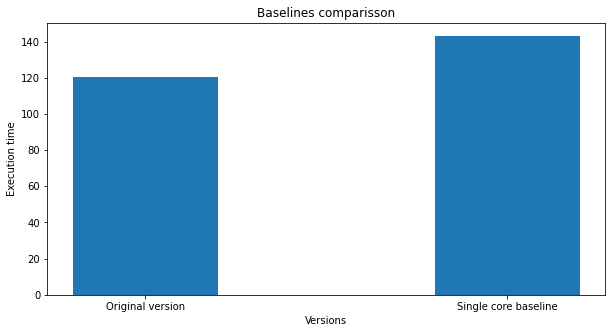

In [14]:
# creating the dataset
data = {'Original version':get_average(baseline), 'Single core baseline':get_average(baseline_single_core)}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
 
plt.xlabel("Versions")
plt.ylabel("Execution time")
plt.title("Baselines comparisson")
plt.show()

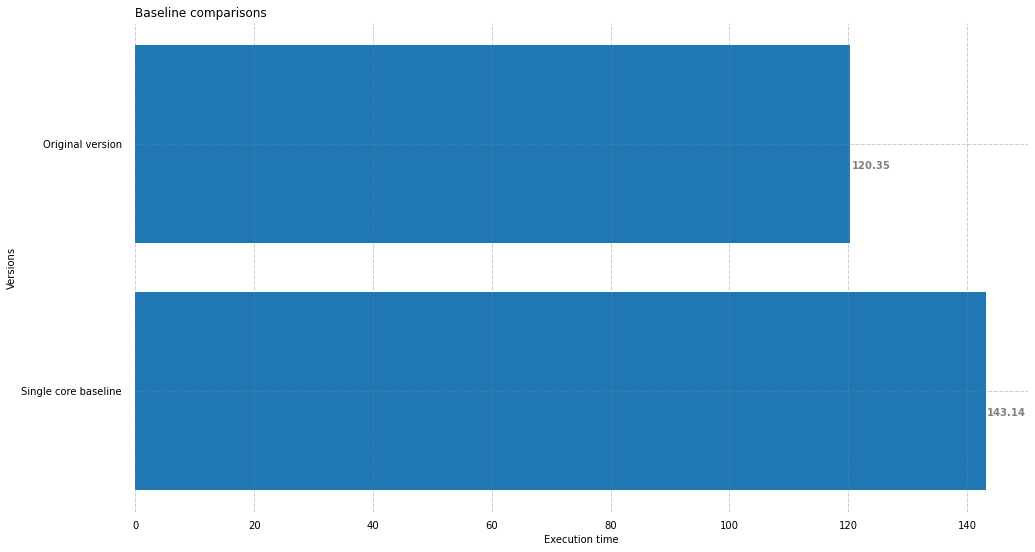

In [15]:
def plot_comparisson(names, values):
 
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(names, values)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.8)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')

    # Add Plot Title
    ax.set_title('Baseline comparisons',
                 loc ='left')
    plt.ylabel("Versions")
    plt.xlabel("Execution time")
    # Show Plot
    plt.show()
    
    
names = ["Original version", "Single core baseline"]
values = [get_average(baseline),get_average(baseline_single_core)]
plot_comparisson(names,values)

# Comparing results

In [16]:
def group_mean(dataframe, groups= default_groups):
    ss = group_by(dataframe,groups)
    return ss.mean()

def get_experimental_values(dataframe: pd.DataFrame, versions=[], xId='cores', yId='value')->dict:
    if(len(versions) == 0):
        versions=get_unique(dataframe, 'version')
    dictionary={}
    for version in versions:
        dataframe_by_versions = dataframe.loc[dataframe['version']==version]
        x = dataframe_by_versions[xId]
        y = dataframe_by_versions[yId]
        dictionary[version] = {'x': x, 'y':y}
    return dictionary

def group_by(dataframe, groups=default_groups):
    return dataframe.groupby(groups, as_index=False)

def get_plottable_experiment(experiment: dict)->dict:
    colors = ['b','g','r','c','m','y','k']
    colors.reverse()
    dictionary = {}
    for version in experiment:
        x=experiment[version]['x']
        y=experiment[version]['y']
        dictionary[version]={'x':x, 'y':y ,'color':colors.pop()}
    return dictionary

16, - 2000


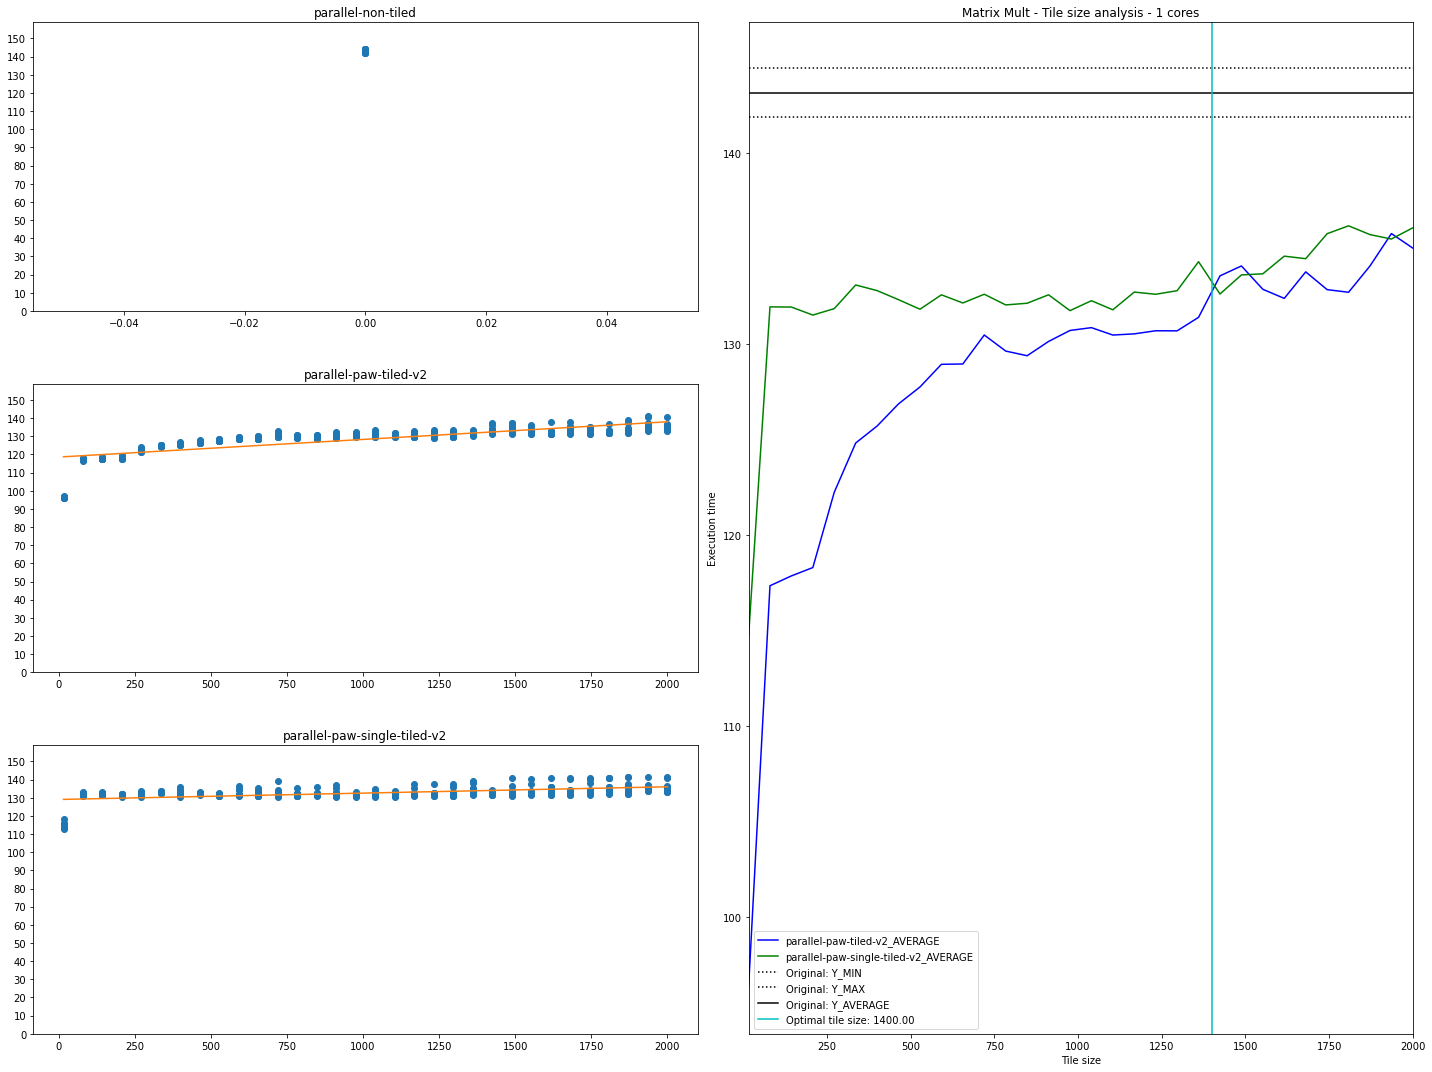

In [37]:
def plot_tiled_experiment(dataframe,cores=4, tick_format_style=default_tick_format_style, optimal_tile_size=None):
    versions = all_versions
    fig=plt.figure(figsize=(20, 15))
    
    # Filtering by core
    plot_df = dataframe[(dataframe.cores==cores)]


    # Getting non tiled values
    non_tiled_experimental_values = get_experimental_values(plot_df,xId='tileSize', yId='value', versions=['parallel-non-tiled'])
    
    #getting min and max of non tiled
    aux_experiment_non_tiled = non_tiled_experimental_values
    non_tiled_x_array = aux_experiment_non_tiled['parallel-non-tiled']['x']
    non_tiled_y_array = aux_experiment_non_tiled['parallel-non-tiled']['y']

    nt_x_min = non_tiled_x_array.min()
    nt_x_max = non_tiled_x_array.max()

    nt_y_min = non_tiled_y_array.min()
    nt_y_max = non_tiled_y_array.max()

    nt_y_mean = non_tiled_y_array.mean()
    
    # Getting values without non tiled data
    tiled_experimental_values = get_experimental_values(group_mean(plot_df),xId='tileSize', yId='value', versions=versions)
    del tiled_experimental_values['parallel-non-tiled']


    
    # Plotting scatter
    scatter_versions=['parallel-non-tiled','parallel-paw-tiled-v2','parallel-paw-single-tiled-v2']
    exp = get_experimental_values(plot_df, xId='tileSize', yId='value', versions=versions)
    plot_exp = get_plottable_experiment(exp)
    
    count=0
    min_y = 0
    max_y = 0
    
    for version in scatter_versions:
        x = plot_exp[version]['x']
        y = plot_exp[version]['y']   
        max_y = max(max_y, y.max())
        
        
    for version in scatter_versions:
        fig.add_subplot(321+count).set_title(version)
        count+=2
        x = plot_exp[version]['x']
        y = plot_exp[version]['y']       

        c = plot_exp[version]
        
        plt.ylim([0, max_y * 1.10])
        plt.yticks(np.arange(0, max_y * 1.10, 10))
        plt.plot(x, y, 'o')
        plt.ticklabel_format(style=tick_format_style, axis='y', scilimits=(0,0))
        
        if len(x) == 1 or len(x.drop_duplicates())==1:
            continue
        
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b)
    


    #plt.show()

    # lines
    #Plotting
    experiment = get_plottable_experiment(tiled_experimental_values)


    x_min=1000000
    x_max=0

    y_min=1000000
    y_max=0

    plt.ticklabel_format(axis='y', scilimits=(0,0))
    title="Matrix Mult - Tile size analysis - "+ str(cores) + " cores"
    
    
    fig.add_subplot(122).set_title(title)
    for version in experiment.keys():
        color = experiment[version]['color']
        x = experiment[version]['x']
        y = experiment[version]['y']
        x_min = min(x_min,x.min())
        x_max = max(x_max,x.max())
        
        y_min = min(y_min, y.min())
        y_max = max(y_max, y.max())

        line, = plt.plot(x, y, color)
        line.set_label(version+"_AVERAGE")
#         line.xticks(np.arange(16,2016,64))
    print(f"{x_min}, - {x_max}")

    plt.xlim(x_min,x_max)
#     plt.xticks(tile_sizes)


#     plt.ylim
    plt.xscale('linear')
    plt.yscale('linear')
    
    plt.ylabel('Execution time')
    plt.xlabel('Tile size')


    plt.axhline(y=nt_y_min, color='black', linestyle=":", label='Original: Y_MIN')
    plt.axhline(y=nt_y_max, color='black', linestyle=":", label='Original: Y_MAX')
    plt.axhline(y=nt_y_mean, color='black', linestyle="-", label='Original: Y_AVERAGE')

    plt.axvline(x=optimal_tile_size, color='c', linestyle='-', label='Optimal tile size: '+"{0:.2f}".format(optimal_tile_size))
    
    plt.tight_layout(h_pad=4)
    plt.legend()

df_tl_mm_ex = filter_by(df, 'matrix-mult','speed-up')

plot_tiled_experiment(df_tl_mm_ex, cores=1, optimal_tile_size=1400, tick_format_style='plain')
# df_tl_mm_ex


## Matrix size
For matrix multiplication we require 3 matrices. Looking for filling up the cache twice we will need to split double of the total amount of values in cache through the 3 matrices.
- Matrices will be **square**
- Data type: **float**

$$
3 \times M \times N  \times Cores \times DataSizeInBytes \leq Cache Size
$$

Given we are using floats for the algorithms, the data size in bytes is 4. So, the final equation looks like this:

$$
3 \times M \times N  \times Cores \times4 \leq Cache Size
$$

### 1 Level tiling over dimension: N.

- Given M keep the same and tiling will be aplying over N. The formula change:

$$
3 \times M \times TileSize  \times Cores \times 4 \leq Cache Size
$$

Solving the equation we obtain that 


$$
TileSize \leq \frac{Cache Size}{3 \times M \times Cores \times 4}
$$

### 2 Level tiling over dimension: N x M.

- Given that N and M variates, we decided to make square chunks, so N=M=TileSize

$$
3 \times TileSize^2  \times Cores \times 4 \leq Cache Size
$$

Solving the equation we obtain that 


$$
TileSize \leq \sqrt{\frac{Cache Size}{3 \times Cores \times 4}}
$$

In [41]:
num_matrices = 3
total_values_per_matrix=double_cache_values/num_matrices
N_matrix = math.ceil(math.sqrt(total_values_per_matrix))
print(f"float type size: {round(type_size_in_bytes)}")
print(f"Total floating numbers to fill up cache: {round(total_values_in_cache)}")
print(f"Total floating numbers to double cache: {round(double_cache_values)}")
print(f"min floating numbers required per matrix (3 matrices): {round(total_values_per_matrix)}")

print(f"rows and cols per matrix: {round(N_matrix)}")
print(f"total floating numbers per matrix (3 matrices): {round(N_matrix*N_matrix)}")

m=N_matrix
n=N_matrix

print(f"is cache smaller: {cache_size_in_bytes < (((8*m)*n)+((4*n)*n))}")
print(f"is worth to parallelize: {m*n*n>100000}")

cores=1
print(f"70% of cache divided by number of cores {math.sqrt(cache_size_in_bytes* 0.7 / 4)/cores}")

print(f"What is the optimal tile size? {cache_size_in_bytes/(3 * m * type_size_in_bytes * cores )}")


float type size: 4
Total floating numbers to fill up cache: 11796480
Total floating numbers to double cache: 23592960
min floating numbers required per matrix (3 matrices): 7864320
rows and cols per matrix: 2805
total floating numbers per matrix (3 matrices): 7868025
is cache smaller: True
is worth to parallelize: True
70% of cache divided by number of cores 2873.5928730423866
What is the optimal tile size? 1401.8395721925133


## Analysis of tile sizes
### 1 Level tiling
We ran the experiment for 1, 4, 7 and 10 cores and we variate the tile sizes through every experiment to see the effect of it in the algorithm.

The tile sizes (rounded) for **1 level tiling** and for every core were the following:

In [48]:
single_core_ts= cache_size_in_bytes/(3 * m * type_size_in_bytes * 1 )
four_core_ts = cache_size_in_bytes/(3 * m * type_size_in_bytes * 4 )
seven_core_ts = cache_size_in_bytes/(3 * m * type_size_in_bytes * 7 )
ten_core_ts = cache_size_in_bytes/(3 * m * type_size_in_bytes * 10 )
print(f"Optimal tile size for 1 core: {round(single_core_ts)}")
print(f"Optimal tile size for 4 cores: {round(four_core_ts)}")
print(f"Optimal tile size for 7 cores: {round(seven_core_ts)}")
print(f"Optimal tile size for 10 cores: {round(ten_core_ts)}")


Optimal tile size for 1 core: 1402
Optimal tile size for 4 cores: 350
Optimal tile size for 7 cores: 200
Optimal tile size for 10 cores: 140


### 2 Level tiling
We ran the experiment for 1, 4, 7 and 10 cores and we variate the tile sizes through every experiment to see the effect of it in the algorithm.

The tile sizes (rounded) for **2 level tiling** and for every core were the following:

In [49]:
single_core_ts= math.sqrt(cache_size_in_bytes/(3 * type_size_in_bytes * 1 ))
four_core_ts = math.sqrt(cache_size_in_bytes/(3 * type_size_in_bytes * 4 ))
seven_core_ts = math.sqrt(cache_size_in_bytes/(3 * type_size_in_bytes * 7 ))
ten_core_ts = math.sqrt(cache_size_in_bytes/(3 * type_size_in_bytes * 10 ))
print(f"Optimal tile size for 1 core: {round(single_core_ts)}")
print(f"Optimal tile size for 4 cores: {round(four_core_ts)}")
print(f"Optimal tile size for 7 cores: {round(seven_core_ts)}")
print(f"Optimal tile size for 10 cores: {round(ten_core_ts)}")

Optimal tile size for 1 core: 1983
Optimal tile size for 4 cores: 991
Optimal tile size for 7 cores: 749
Optimal tile size for 10 cores: 627


In [50]:
for version in all_versions:
    best_configurations = {} ## It saves the configurations for the best execution times 
                             ## for every version {'version-core': {average, std, variation } }
    for core in cores_list:
        results_by_version = filter_by(df,'matrix-mult', 'speed-up',version, core)
        configuration_key = version+"-"+str(core)
        
        
        
results

NameError: name 'results' is not defined

#### def comparing_to_baseline(baseline_data, parallel_baseline_data, comparing_dfs_data):
    names = [baseline_data['name'], parallel_baseline_data['name']]
    values = [get_average(baseline_data['dataframe']), get_average(parallel_baseline_data['dataframe'])]
    for comparing_df_data in comparing_dfs_data:
        comparing_name = comparing_df_data['name']
        comparing_df = comparing_df_data['dataframe']
        names.append(comparing_name)
        values.append(get_average(comparing_df))
    plot_comparisson(names,values)
        
    

tile_size=tile_sizes[2]
print(tile_size)

version = 'parallel-paw-tiled-v2'
comparing_df_raw = filter_by(df,'matrix-mult', 'speed-up',version , 1, tileSize=tile_size)
comparing_df, average, std = clean(comparing_df_raw)

# variation, minv,maxv = get_variation(comparing_df)
# print(f"average: {average}, std: {std}")
# print(f"min: {minv}, max: {maxv} ")
# print(f"variation {variation*100}")
# comparing_df   

comparing_df_raw_4 = filter_by(df,'matrix-mult', 'speed-up',version, 4, tileSize=tile_size)
comparing_df_4, average, std = clean(comparing_df_raw_4)

comparing_df_raw_7 = filter_by(df,'matrix-mult', 'speed-up',version, 7, tileSize=tile_size)
comparing_df_7, average, std = clean(comparing_df_raw_7)

comparing_df_raw_10 = filter_by(df,'matrix-mult', 'speed-up', version, 10, tileSize=tile_size)
comparing_df_10, average, std = clean(comparing_df_raw_10)

bbr_4 = filter_by(df,'matrix-mult', 'speed-up','parallel-non-tiled', 4, tileSize=0)
bb_4, average, std = clean(bbr_4)
comparing_dataframes = [
    {'name': version+" - 1", 'dataframe': comparing_df },
    {'name': version+" - 4", 'dataframe': comparing_df_4 },
    {'name': version+" - 7", 'dataframe': comparing_df_7 },
    {'name': version+" - 10", 'dataframe': comparing_df_10 }
]
baseline_data = {
    'name': 'Original non-parallel version'+"- Fully serial, TileSize:Inf",
    'dataframe': baseline
}
parallel_baseline_data = {
    'name': 'non-parallel version'+"- Cores: 4, TileSize:Inf",
    'dataframe': bb_4
}
comparing_to_baseline(baseline_data,parallel_baseline_data,comparing_dataframes)

In [50]:
baseline_data = {'Original version':get_average(baseline), 'Single core baseline':get_average(baseline_single_core)}
